**MENGIMPORT FILE KENCUR**

In [ ]:
# prompt: MENGIMPORT FILE

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving bio kencur new.xlsx to bio kencur new.xlsx
User uploaded file "bio kencur new.xlsx" with length 9752 bytes


In [ ]:
uploaded = files.upload()

**MEMBACA DATA**

In [ ]:
import pandas as pd # Import the pandas library and assign it to the alias 'pd'

df = pd.read_excel("bio kencur new.xlsx")

In [ ]:
print(df.head())

     Kecamatan  Produksi Kencur  Luas Panen Kencur
0      Ciwidey                0                  0
1    Rancabali             4804               1199
2   Pasirjambu             1250                600
3      Cimaung            27411               8458
4  Pangalengan                0                  0


In [ ]:
# Statistik deskriptif dari data biofarmaka kencur
df.describe()


,Produksi Kencur,Luas Panen Kencur
count,31.000000,31.000000
mean,2900.806452,1101.258065
std,6935.460804,2183.303689
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1325.000000,899.500000
max,27411.000000,8458.000000


**PREPROCESSING DATA KENCUR**

In [ ]:
# PENGECEKAN DATA MISSING ATAU MISSING VALUE
print(df[['Produksi Kencur', 'Luas Panen Kencur']].isnull().sum())

Produksi Kencur      0
Luas Panen Kencur    0
dtype: int64


Terdapat 0 missing value atau nilai kosong pada setiap kolom numeriknya.

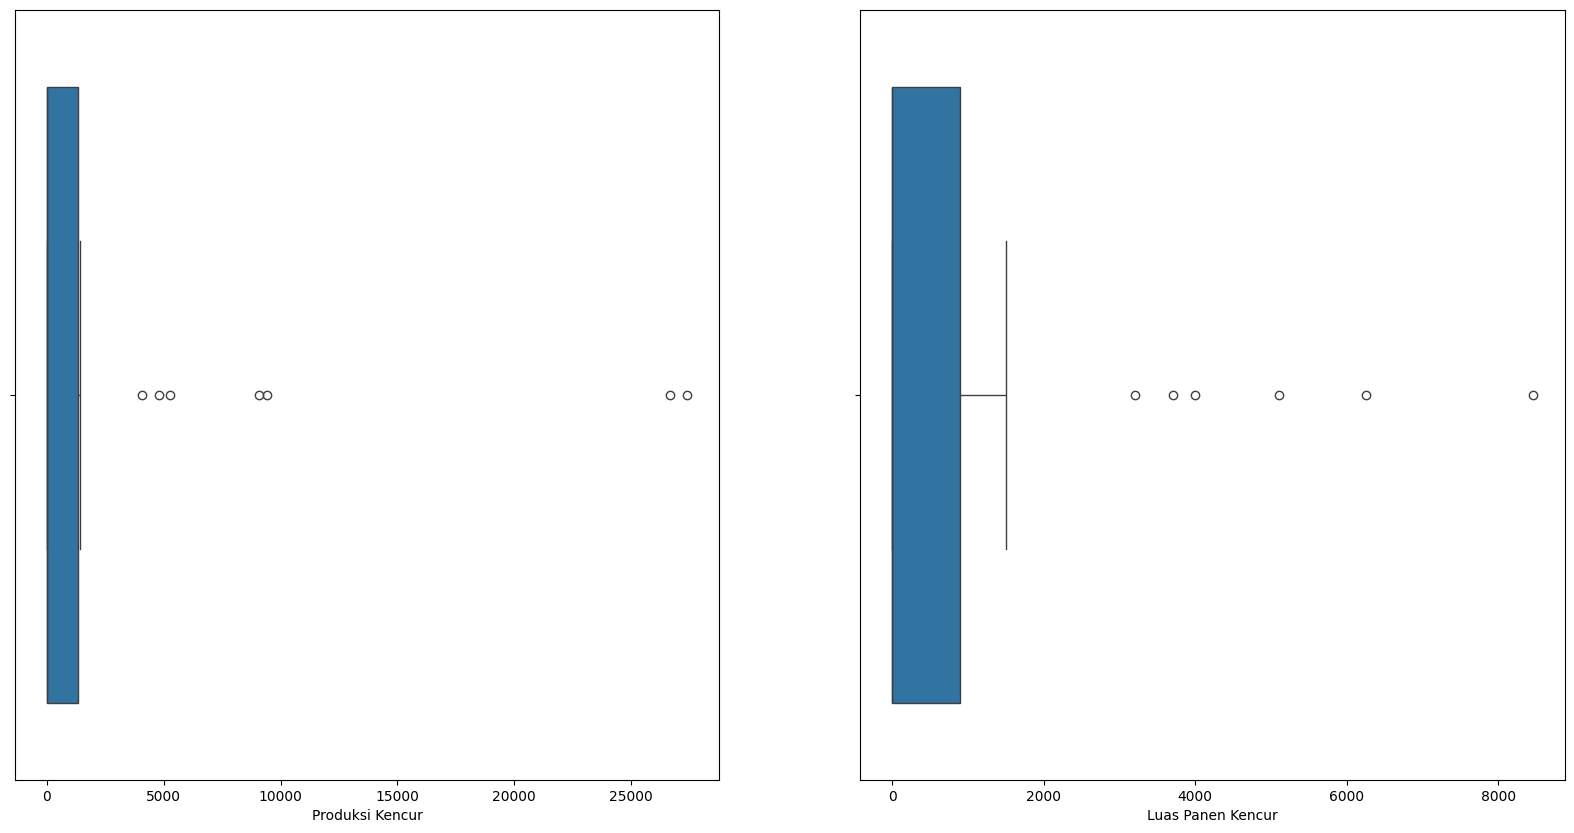

In [ ]:
# PENGECEKAN OUTLIER PADA BOXPLOT
#Visualisasi variabel numerik
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module
import seaborn as sns  # Assuming seaborn is used later, import it as well

var_num = ['Produksi Kencur', 'Luas Panen Kencur']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axs = axs.flatten()

for i, var in enumerate(var_num):
    sns.boxplot(x=var, data=df, ax=axs[i])


plt.show()

Terdapat outlier pada data maka pengujian cluster yang tahan terhadap outlier dengan hirarki adalah Complete Linkage

In [ ]:
pip install factor-analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42564 sha256=35820074eb7ba94d9ff0f122f43b2d49c7f5a1ccbe5c72e898f4ae64ba8a479f
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor-analyzer


1. UJI ASUMSI BARLET

In [ ]:
import pandas as pd
from scipy.stats import bartlett

# Misalkan kita menggunakan dua variabel: 'PDRB_boxcox' dan 'Jumlah Penduduk Miskin_boxcox'
# Pastikan Anda sudah mengimpor dataset df yang mengandung kedua variabel ini.

# Mengambil data dari variabel yang akan diuji
data1 = df['Produksi Kencur']
data2 = df['Luas Panen Kencur']

# Melakukan uji Bartlett
stat, p_value = bartlett(data1, data2)

# Menampilkan hasil
print(f'Statistik Bartlett: {stat}')
print(f'P-Value: {p_value}')

# Menentukan kesimpulan dari p-value
alpha = 0.05
if p_value < alpha:
    print("Tolak H0: Varians tidak homogen (heteroskedastisitas ada).")
else:
    print("Gagal tolak H0: Varians homogen (homoskedastisitas ada).")

Statistik Bartlett: 32.88119767390199
P-Value: 9.796620880677512e-09
Tolak H0: Varians tidak homogen (heteroskedastisitas ada).


2. UJI KMO MSA

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
import pandas as pd

# Pilih dua kolom yang relevan
var = ['Produksi Kencur', 'Luas Panen Kencur']
data_selected = df[var].dropna()

# Hitung KMO
kmo_all, kmo_model = calculate_kmo(data_selected)

print(f'KMO Model Value: {kmo_model}')

KMO Model Value: 0.5000000000000003


interpretasi : data masih cukup layak untuk dilakukan analisis

3. UJI MULTIKOLINEARITAS

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np # Import numpy library

# Dataframe yang hanya berisi kolom var numerik
X = df[['Produksi Kencur', 'Luas Panen Kencur']]

# Menambahkan konstanta agar model bisa mengkalkulasi VIF
X = pd.concat([pd.Series([1]*len(X), name='Intercept'), X], axis=1)

# Check for infinite values and replace with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)


# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Menghitung VIF untuk setiap variabel
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Menampilkan VIF
print(vif_data)

# NOTE: tidak ada multikol jika nilai VIF < 5 karena dari output dibawah nilai VIF PDRB dan jumlah penduduk miskin < 5 maka tidak ada multikol

            Variable       VIF
0          Intercept  1.267094
1    Produksi Kencur  4.706804
2  Luas Panen Kencur  4.706804


Interpretasi : Dengan nilai VIF 4.706804, artinya variabel independen dalam model memiliki korelasi yang cukup kuat satu sama lain, namun belum mencapai level yang kritis. Maka masih aman dilakukan pada pengujian selanjutnya.

**STANDARISASI DATA KENCUR**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Dataframe yang berisi kolom produksi kencur dan luas panennya
df_to_scale = df[['Produksi Kencur', 'Luas Panen Kencur']]

# Inisialisasi scaler
scaler = StandardScaler()

# Menerapkan standarisasi pada kolom
df_scaled = scaler.fit_transform(df_to_scale)

# Mengubah kembali hasil menjadi DataFrame dengan kolom baru
df_scaled = pd.DataFrame(df_scaled, columns=['Produksi Kencur_scaled', 'Luas Panen Kencur_scaled'])

# Menampilkan hasil standarisasi
print(df_scaled.head())

#NOTE: nilai yang negatif artinya data asli berada di bawah rata-rata dan begitupun sebaliknya

   Produksi Kencur_scaled  Luas Panen Kencur_scaled
0               -0.425171                 -0.512738
1                0.278951                  0.045508
2               -0.241959                 -0.233382
3                3.592457                  3.425245
4               -0.425171                 -0.512738


Menyimpan data yang telah di standarisasi ke bentuk excel

In [ ]:
pip install pandas openpyxl scikit-learn

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Asumsikan df adalah DataFrame yang telah ada
# Dataframe yang berisi kolom produksi kencur dan luas panennya
df_to_scale = df[['Produksi Kencur', 'Luas Panen Kencur']]

# Inisialisasi scaler
scaler = StandardScaler()

# Menerapkan standarisasi pada kolom
df_scaled = scaler.fit_transform(df_to_scale)

# Mengubah kembali hasil menjadi DataFrame dengan kolom baru
df_scaled = pd.DataFrame(df_scaled, columns=['Produksi Kencur_scaled', 'Luas Panen Kencur_scaled'])

# Menampilkan hasil standarisasi
print(df_scaled.head())

# Menyimpan DataFrame yang telah terstandarisasi ke dalam file Excel
output_file = 'data_scaled.xlsx'  # Ganti nama file sesuai kebutuhan
df_scaled.to_excel(output_file, index=False)

print(f'Data terstandarisasi telah disimpan ke {output_file}')

   Produksi Kencur_scaled  Luas Panen Kencur_scaled
0               -0.425171                 -0.512738
1                0.278951                  0.045508
2               -0.241959                 -0.233382
3                3.592457                  3.425245
4               -0.425171                 -0.512738
Data terstandarisasi telah disimpan ke data_scaled.xlsx


**HITUNG JARAK EUCLIDEAN**

JARAK EUCLIDEAN DIDAPAT DARI DATA YG SUDAH DI STANDARISASI

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Asumsi df_scaled adalah DataFrame yang sudah distandarisasi atau di-normalisasi
# dengan dua kolom 'Produksi Kencur_log_scaled' dan 'Luas Panen Kencur_log_scaled'

# Menghitung jarak Euclidean antar pasangan objek
distance_matrix = cdist(df_scaled, df_scaled, metric='euclidean')

# Konversi ke DataFrame agar lebih mudah dibaca
distance_df = pd.DataFrame(distance_matrix,
                           columns=[f'Objek_{i+1}' for i in range(df_scaled.shape[0])],
                           index=[f'Objek_{i+1}' for i in range(df_scaled.shape[0])])

# Menampilkan hasil jarak antar objek
print(distance_df.head())  # Hanya menampilkan 5 baris pertama untuk kemudahan

          Objek_1   Objek_2   Objek_3   Objek_4   Objek_5   Objek_6   Objek_7  \
Objek_1  0.000000  0.898569  0.334075  5.625748  0.000000  0.000000  2.205875   
Objek_2  0.898569  0.000000  0.590869  4.733069  0.898569  0.898569  1.345259   
Objek_3  0.334075  0.590869  0.000000  5.299839  0.334075  0.334075  1.873542   
Objek_4  5.625748  4.733069  5.299839  0.000000  5.625748  5.625748  3.446219   
Objek_5  0.000000  0.898569  0.334075  5.625748  0.000000  0.000000  2.205875   

          Objek_8   Objek_9  Objek_10  ...  Objek_22  Objek_23  Objek_24  \
Objek_1  0.000000  3.200089  0.000000  ...  0.000000  0.000000  0.090250   
Objek_2  0.898569  2.433939  0.898569  ...  0.898569  0.898569  0.808543   
Objek_3  0.334075  2.870275  0.334075  ...  0.334075  0.334075  0.252799   
Objek_4  5.625748  2.876186  5.625748  ...  5.625748  5.625748  5.536850   
Objek_5  0.000000  3.200089  0.000000  ...  0.000000  0.000000  0.090250   

         Objek_25  Objek_26  Objek_27  Objek_28  Objek_2

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Asumsi df_scaled adalah DataFrame yang sudah distandarisasi atau di-normalisasi
# dengan dua kolom 'Produksi Kencur_log_scaled' dan 'Luas Panen Kencur_log_scaled'

# Menghitung jarak Euclidean antar pasangan objek
distance_matrix = cdist(df_scaled, df_scaled, metric='euclidean')

# Konversi ke DataFrame agar lebih mudah dibaca
distance_df = pd.DataFrame(distance_matrix,
                           columns=[f'Objek_{i+1}' for i in range(df_scaled.shape[0])],
                           index=[f'Objek_{i+1}' for i in range(df_scaled.shape[0])])

# Menyimpan DataFrame ke file Excel
distance_df.to_excel("output_matriks.xlsx", engine='openpyxl', index=True)  # menggunakan openpyxl
# atau
# distance_df.to_excel("output_matriks.xlsx", engine='xlsxwriter', index=True)  # menggunakan xlsxwriter

print("Matriks jarak telah disimpan ke output_matriks.xlsx")


Matriks jarak telah disimpan ke output_matriks.xlsx


**MENENTUKAN NILAI K**

Jumlah Cluster: 2, Silhouette Score: 0.8215
Jumlah Cluster: 3, Silhouette Score: 0.8409
Jumlah Cluster: 4, Silhouette Score: 0.8034
Jumlah Cluster: 5, Silhouette Score: 0.7756
Jumlah Cluster: 6, Silhouette Score: 0.7632
Jumlah Cluster: 7, Silhouette Score: 0.7483
Jumlah Cluster: 8, Silhouette Score: 0.7195
Jumlah Cluster: 9, Silhouette Score: 0.6929
Jumlah Cluster: 10, Silhouette Score: 0.6871


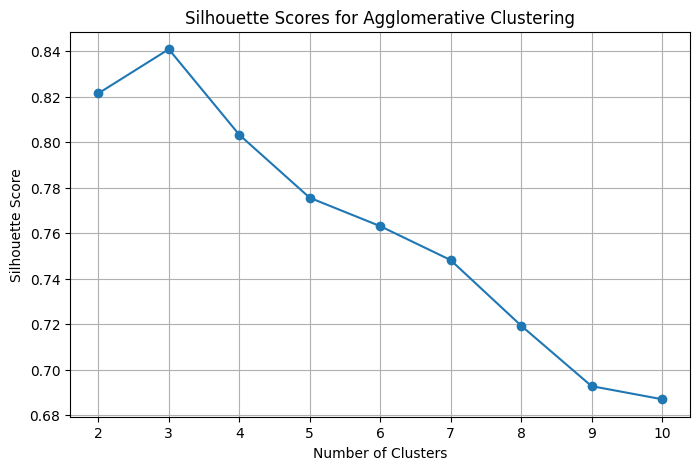

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Data yang sudah distandarisasi (misalnya df_scaled)
X = df_scaled.values  # Pastikan untuk menggunakan nilai dari DataFrame

# List untuk menyimpan nilai silhouette score
silhouette_scores = []

# Uji Agglomerative Clustering untuk berbagai jumlah cluster (misalnya dari 2 hingga 10)
cluster_range = range(2, 11)
for k in cluster_range:
    # Inisialisasi model Agglomerative Clustering dengan complete linkage
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agglomerative.fit_predict(X)

    # Menghitung silhouette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

    # Menampilkan jumlah cluster dan nilai silhouette score
    print(f"Jumlah Cluster: {k}, Silhouette Score: {silhouette_avg:.4f}")

# Plotting Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid()
plt.show()

Karena hasil yang memiliki nilai paling besar itu adalah cluster 3 maka nilai k yaitu 3 cluster

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/

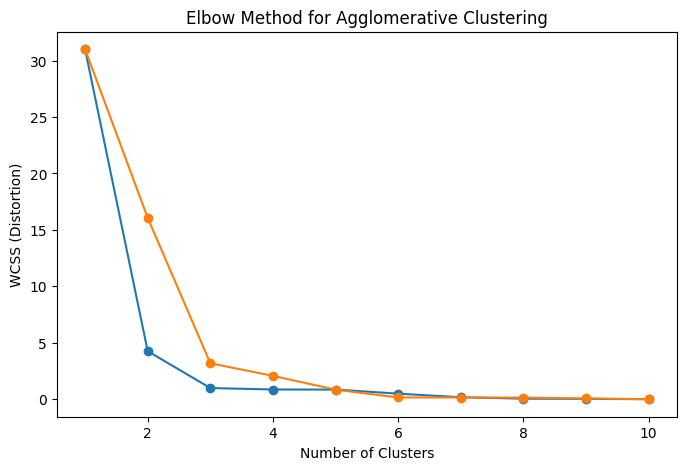

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import numpy as np

# Fungsi untuk menghitung WCSS (Sum of Squared Distances)
def calculate_wcss(X, labels):
    wcss = 0
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

# Mencari jumlah cluster optimal menggunakan elbow method dengan agglomerative clustering
wcss = []
for i in range(1, 11):
    clustering = AgglomerativeClustering(n_clusters=i, linkage='complete')
    labels = clustering.fit_predict(df_scaled)
    wcss.append(calculate_wcss(df_scaled, labels))

# Plotting the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Distortion)')
plt.show()


INI MAH NGITUNG SSE DARI DATA YG DI STANDARISASI

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

# Misalkan df_scaled adalah data yang telah distandarisasi
# df_scaled = pd.DataFrame(data_scaled)

# Tentukan jumlah cluster (misalkan k=3) dan buat model AgglomerativeClustering dengan linkage 'complete'
k = 3
model = AgglomerativeClustering(n_clusters=k, linkage='complete')

# Fit model dan prediksi cluster untuk tiap data
cluster_labels = model.fit_predict(df_scaled)

# Menambahkan kolom cluster ke df_scaled
df_scaled['cluster'] = cluster_labels

# Fungsi untuk menghitung centroid dari setiap cluster
centroids = df_scaled.groupby('cluster').mean().values

# Menghitung SSE
sse = 0
for i in range(k):
    cluster_data = df_scaled[df_scaled['cluster'] == i].drop(columns=['cluster']).values
    centroid = centroids[i]
    sse += np.sum((cluster_data - centroid) ** 2)

print("SSE (Sum of Squared Errors):", sse)


SSE (Sum of Squared Errors): 4.176388367012859


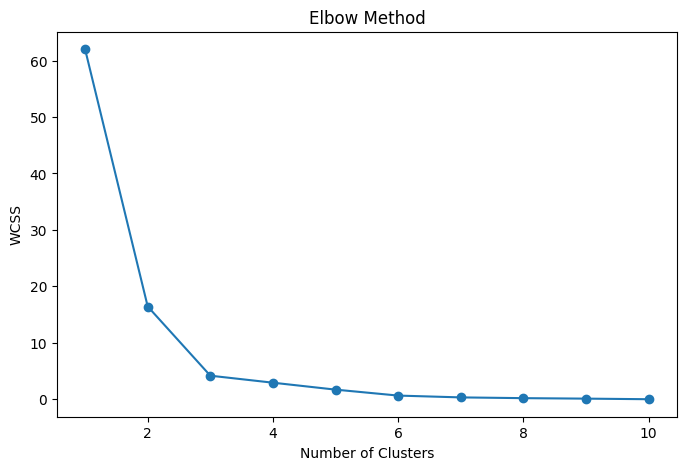

In [ ]:
##ELBOW METHODE##
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Mencari jumlah cluster optimal menggunakan Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**CLUSTERING DENGAN COMPLETE LINKAGE HIRARKI**

    Produksi Kencur_scaled  Luas Panen Kencur_scaled  Cluster
0                -0.425171                 -0.512738        2
1                 0.278951                  0.045508        2
2                -0.241959                 -0.233382        2
3                 3.592457                  3.425245        1
4                -0.425171                 -0.512738        2
5                -0.425171                 -0.512738        2
6                 0.952586                  1.209955        0
7                -0.425171                 -0.512738        2
8                 0.906270                  2.397216        0
9                -0.425171                 -0.512738        2
10                0.171369                  0.977159        0
11               -0.425171                 -0.512738        2
12               -0.425171                 -0.512738        2
13               -0.425024                 -0.512272        2
14               -0.425171                 -0.512738        2
15      

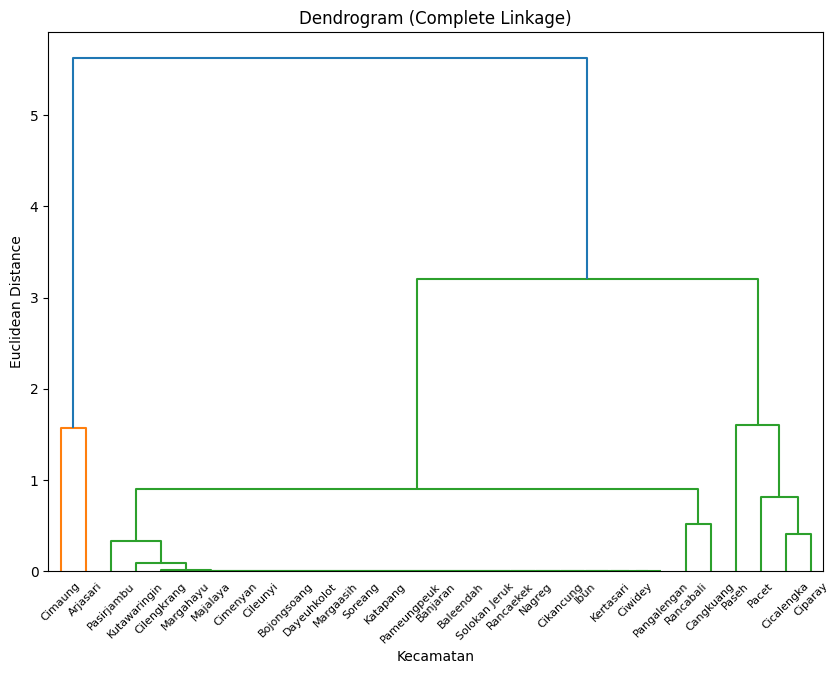

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Menggunakan metode Agglomerative Clustering dengan complete linkage
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Melakukan fitting dan prediksi terhadap data
cluster_labels = clustering.fit_predict(df_scaled)

# Menambahkan hasil cluster ke DataFrame
df_scaled['Cluster'] = cluster_labels

# Menampilkan hasil cluster
print(df_scaled)

# Visualisasi Dendrogram menggunakan SciPy
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Complete Linkage)")
plt.xlabel("Kecamatan")
plt.ylabel("Euclidean Distance")

# Menghitung linkage matrix
linkage_matrix = sch.linkage(df_scaled.drop(columns='Cluster'), method='complete')

# Membuat dendrogram dengan label dari df['Kecamatan']
dendrogram = sch.dendrogram(linkage_matrix, labels=df['Kecamatan'].tolist())
# The labels argument is passed to dendrogram, not linkage

plt.show()

    Produksi Kencur_scaled  Luas Panen Kencur_scaled  Cluster
0                -0.425171                 -0.512738        2
1                 0.278951                  0.045508        2
2                -0.241959                 -0.233382        2
3                 3.592457                  3.425245        1
4                -0.425171                 -0.512738        2
5                -0.425171                 -0.512738        2
6                 0.952586                  1.209955        0
7                -0.425171                 -0.512738        2
8                 0.906270                  2.397216        0
9                -0.425171                 -0.512738        2
10                0.171369                  0.977159        0
11               -0.425171                 -0.512738        2
12               -0.425171                 -0.512738        2
13               -0.425024                 -0.512272        2
14               -0.425171                 -0.512738        2
15      

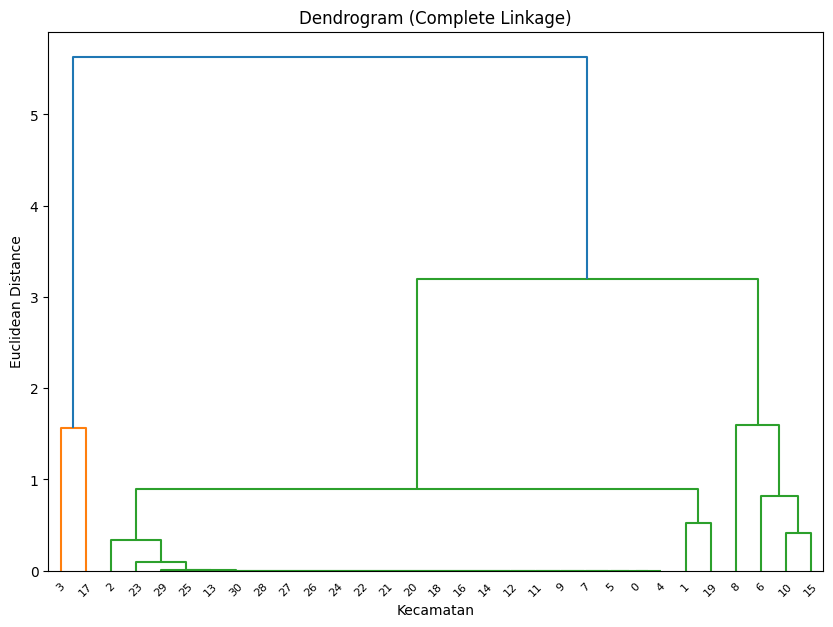

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Menggunakan metode Agglomerative Clustering dengan complete linkage
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Melakukan fitting dan prediksi terhadap data
cluster_labels = clustering.fit_predict(df_scaled)

# Menambahkan hasil cluster ke DataFrame
df_scaled['Cluster'] = cluster_labels

# Menampilkan hasil cluster
print(df_scaled)

# Visualisasi Dendrogram menggunakan SciPy
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Complete Linkage)")
plt.xlabel("Kecamatan")
plt.ylabel("Euclidean Distance")
dendrogram = sch.dendrogram(sch.linkage(df_scaled.drop(columns='Cluster'), method='complete'))
plt.show()



**MENGHITUNG RATA RATA DARI SETIAP CLUSTER**

In [ ]:
# Gabungkan data asli dengan label cluster (pastikan index antara df dan df_scaled sama)
df['Cluster'] = cluster_labels

# Menghitung rata-rata setiap cluster hanya untuk kolom numerik dari data asli
rata_rata_per_cluster = df.groupby('Cluster').mean(numeric_only=True)
# The numeric_only=True argument is added to the mean function

# Menampilkan hasil rata-rata
print(rata_rata_per_cluster)

         Produksi Kencur  Luas Panen Kencur
Cluster                                    
0                 6961.0            4287.50
1                27030.5            6779.00
2                  320.8             137.24
